In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Link Prediction With Graph Neural Networks

In this example, we will use the Cora citation network [available for download here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz). Nodes are papers and links represent citations among papers. The objective is to use a small sample of positive (i.e., existing) links and negative (i.e, non-existing) links to build a model that can predict whther two nodes have a citation relationship.

## STEP 1: Load and Preprocess Dataset
Let's begin by loading and preprocessing the dataset.  By default, *ktrain* will holdout *10%* (i.e., `val_pct=0.1`) of the links for validation (along with an equal number of negative links).  An additional `train_pct` of links will be taken as the training set.  Here, we set `train_pct=0.1`, which is also the default.

In [2]:
import ktrain
from ktrain import graph as gr

# load data with supervision ratio of 10%
(trn, val, preproc) = gr.graph_links_from_csv(
                                             'data/cora/cora.content', # node attributes/labels
                                             'data/cora/cora.cites',   # edge list
                                              train_pct=0.1, sep='\t')

Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


I0408 21:56:28.759857 140224628672320 utils.py:129] Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
I0408 21:56:28.761173 140224628672320 utils.py:141] NumExpr defaulting to 8 threads.


** Sampled 527 positive and 527 negative edges. **
** Sampled 475 positive and 475 negative edges. **


In [3]:
print('original graph: %s nodes and %s edges' % (preproc.G.number_of_nodes(), preproc.G.number_of_edges()))

original graph: 2708 nodes and 5278 edges


In [4]:
print('validation graph: nodes: %s, links:%s' % (val.graph.number_of_nodes(), val.graph.number_of_edges()))

validation graph: nodes: 2708, links:4751


In [5]:
print('training graph: nodes: %s, links:%s' % (trn.graph.number_of_nodes(), trn.graph.number_of_edges()))

training graph: nodes: 2708, links:4276


## STEP 2: Build a Graph Neural Network for Link Prediction
Next, we build a graph neural network model.  *ktrain* currently supports [GraphSAGE models](https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf) for link prediction.

In [6]:
gr.print_link_predictors()

graphsage: GraphSAGE:  http://arxiv.org/pdf/1607.01759.pdf


In [7]:
model = gr.graph_link_predictor('graphsage', trn, preproc)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


We will wrap the model and data in a `Learner` object to facilitate training. For instance, let's set the global weight decay to 0.01.

In [8]:
learner = ktrain.get_learner(model, train_data=trn, val_data=val)

In [9]:
learner.set_weight_decay(wd=0.01)

/home/amaiya/projects/ghub/ktrain/ktrain/core.py:266: UserWarning: recompiling model to use AdamWeightDecay as opimizer with weight decay of 0.01
  warnings.warn('recompiling model to use AdamWeightDecay as opimizer with weight decay of %s' % (wd) )


## STEP 3: Estimate Learning Rate Using Learning-Rate-Finder

simulating training for different learning rates... this may take a few moments...
Train for 29 steps
Epoch 1/10
29/29 [==============================] - 4s 122ms/step - loss: 1.1456 - accuracy: 0.6089
Epoch 2/10
29/29 [==============================] - 4s 121ms/step - loss: 1.0372 - accuracy: 0.5828
Epoch 3/10
29/29 [==============================] - 4s 130ms/step - loss: 1.0973 - accuracy: 0.5763
Epoch 4/10
29/29 [==============================] - 4s 124ms/step - loss: 1.1659 - accuracy: 0.6100
Epoch 5/10
29/29 [==============================] - 4s 126ms/step - loss: 0.9463 - accuracy: 0.5686
Epoch 6/10
29/29 [==============================] - 4s 125ms/step - loss: 0.5792 - accuracy: 0.7059
Epoch 7/10
29/29 [==============================] - 4s 127ms/step - loss: 0.4030 - accuracy: 0.8170
Epoch 8/10
29/29 [==============================] - 4s 124ms/step - loss: 0.5284 - accuracy: 0.8344
Epoch 9/10
29/29 [==============================] - 4s 123ms/step - loss: 0.4732 - accuracy: 0.821

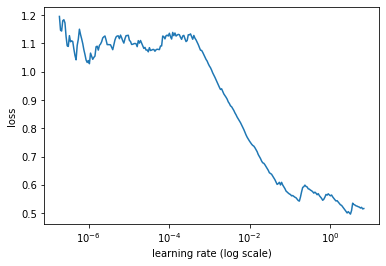

In [11]:
learner.lr_find(show_plot=True, max_epochs=10)

## STEP 4: Train Model With [1Cycle](https://arxiv.org/pdf/1803.09820.pdf) Learning Rate Schedule]

In [10]:
learner.fit_onecycle(0.01, 5)



begin training using onecycle policy with max lr of 0.01...
Train for 30 steps, validate for 33 steps
Epoch 1/5
30/30 [==============================] - 10s 334ms/step - loss: 0.8107 - accuracy: 0.6168 - val_loss: 0.5360 - val_accuracy: 0.7543
Epoch 2/5
30/30 [==============================] - 8s 275ms/step - loss: 0.5096 - accuracy: 0.8011 - val_loss: 0.4129 - val_accuracy: 0.8406
Epoch 3/5
30/30 [==============================] - 8s 282ms/step - loss: 0.3617 - accuracy: 0.8789 - val_loss: 0.4621 - val_accuracy: 0.8254
Epoch 4/5
30/30 [==============================] - 8s 278ms/step - loss: 0.3156 - accuracy: 0.9032 - val_loss: 0.4169 - val_accuracy: 0.8273
Epoch 5/5
30/30 [==============================] - 8s 282ms/step - loss: 0.2214 - accuracy: 0.9442 - val_loss: 0.4421 - val_accuracy: 0.8302


## Make Predictions

We will create a `Predictor` object and make predictions.  The predict method accepts a `networkx` graph with node features stored as node attributes and a list of edges (tuples of node IDs into the graph).  The model will predict whether each edge should exist or not.  Since we are making predictions existing edges in the graph, we expect to return a 1 (i.e., a string label of 'positive') for each input.

In [12]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [18]:
predictor.predict(preproc.G, list(preproc.G.edges())[:5])

array(['positive', 'positive', 'positive', 'positive', 'positive'],
      dtype='<U8')

In [19]:
predictor.save('/tmp/mylinkpred')

In [20]:
reloaded_predictor = ktrain.load_predictor('/tmp/mylinkpred')

In [21]:
reloaded_predictor.get_classes()

['negative', 'positive']

In [22]:
reloaded_predictor.predict(preproc.G, list(preproc.G.edges())[:5], return_proba=True)

[[0.07637989521026611, 0.9236201],
 [0.21356898546218872, 0.786431],
 [0.1649041771888733, 0.8350958],
 [0.1919359564781189, 0.80806404],
 [0.12360215187072754, 0.87639785]]